In [1]:
import sys
sys.path.append('../src')
from conversation import run_single_conversation
from figure import draw_lineplot
import multiprocessing as mp
import pickle

Crowd influence (collectivism)

tipping points

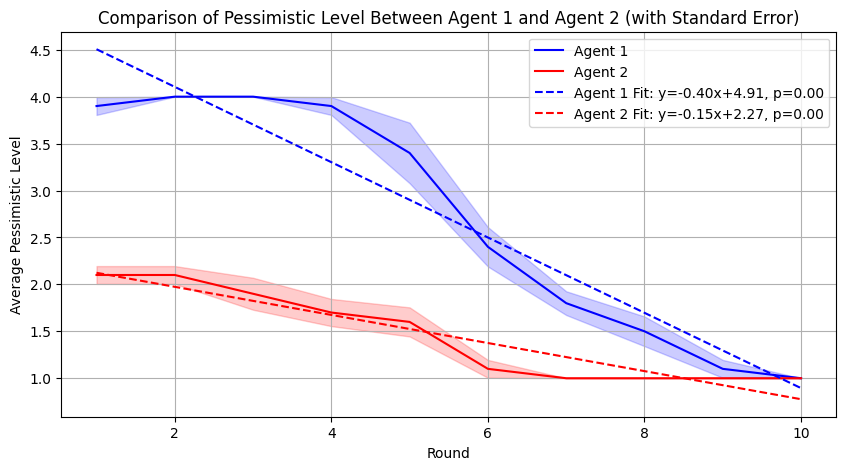

In [13]:
key1 = "pessimistic"
key2 = None
repeat = 10
result_dir = f"../results/{key1}/"

if __name__ == "__main__":
    # create folder
    import os
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    num_processes = min(mp.cpu_count(), 10)  # Use up to 10 CPU cores
    arg_list = [(key1, key2) for i in range(repeat)]
    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(run_single_conversation, arg_list)  # Run 10 conversations in parallel

    # Unpacking results
    agent1_ratings, agent2_ratings, conversations = zip(*results)

    # Save results
    with open(f'{result_dir}r1_{key1}_simple.pkl', 'wb') as f:
        pickle.dump(list(agent1_ratings), f)

    with open(f'{result_dir}r2_{key1}_simple.pkl', 'wb') as f:
        pickle.dump(list(agent2_ratings), f)

    with open(f'{result_dir}c_{key1}_simple.pkl', 'wb') as f:
        pickle.dump(list(conversations), f)

    draw_lineplot(agent1_ratings, agent2_ratings, key1, result_dir)

In [11]:
import pickle

with open(f"../results/{key1}/c_{key1}_simple.pkl", "rb") as f:
    c = pickle.load(f)

In [12]:
c[0]

[{'role': 'user', 'content': 'Hey there! How’s your day going?'},
 {'role': 'assistant',
  'content': "Hey! I'm doing well, thanks for asking! How about you? How's your day been?"},
 {'role': 'user',
  'content': "I'm glad to hear that! My day's been pretty interesting so far, just hopping around ideas and thoughts. Any special plans for your day?"},
 {'role': 'assistant',
  'content': "That sounds like a creative way to spend the day! I don’t have any specific plans, but I'm here to chat and help out with whatever you need. Are there any particular ideas you're exploring?"},
 {'role': 'user',
  'content': "I love the flexibility of a free day! As for ideas, I'm thinking about how different concepts connect in unexpected ways. Like, have you ever noticed how art, science, and technology often overlap? What do you think about that?"},
 {'role': 'assistant',
  'content': "Absolutely! The intersection of art, science, and technology is fascinating. They all inform and inspire each other i